# Bayesian Linear Regression

## Overview

This lab focuses on implementing some of the requisite calculations and manipulations for applying Bayesian linear regression models.

Exercises include:

- computing the posterior distribution,
- computing the marginal likelihood,
- evaluating and choosing regularisation parameters,
- obtaining posterior mean models,
- calculating error-bars (the predictive variance)


## Setup

### Support code

To get started, the code cell below imports the requisite standard Python modules, plus a setup module `cm50268_lab1_setup` specific to this lab. This module contains:

- the class `DataGenerator` to synthesise all the data sets needed,
- the class `RBFGenerator` to create the necessary Gaussian "RBF" basis matrices for varying data sets,
- the function `error_rms` to simply calculate errors for a given target values $t$ and corresponding model output $y$.

We also set some "constants" below: data set sizes and the generative noise standard deviation, which we fix at $\sigma=0.1$ for the entire exercise.


In [2]:
%matplotlib inline
# Standard modules
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

import cm50268_lab1_setup as lab1
#
N_train = 12
N_val   = N_train
N_test  = 250
#
sigma = 0.1
s2    = sigma**2


### Generate Data
We synthesise three data sets:
- training set of size $N_{train}=12$ with added noise $\sigma=0.1$
- validation set of size $N_{val}=12$ with added noise $\sigma=0.1$
- test set of size $N_{test}=250$ with **no noise** and which **covers the full $x$-space**

**Note:** we assume throughtout that $\sigma$ is known and fixed. A feature of the test set here is that *it will include data from a region where there is no training data*.

### Generate Basis
For our linear model, we use as many functions as data points (a "complete" basis), comprising $N-1$ equally-spaced Gaussian functions (of width 1), plus a fixed "bias" or "offset". If we call `evaluate` on the basis generator, we get a $N\times{}M$ matrix $\mathbf{\Phi}$ returned, where each column / row contains the output of each basis function on each data point respectively: that is, $\mathbf{\Phi}_{nm} = \phi_m(x_n)$. The use of a bias means the first column contains simply a fixed value of one. 

For the training and validation set, this matrix $\mathbf{\Phi}$ will be $12\times 12$, whereas for the test set it will be $250 \times 12$.

For illustration, the data and the underlying "truth" (sine wave) are shown below, with basis functions overlaid.

<img src="data-and-basis.png" alt="Data and basis" style="width: 500px;"/>


In [4]:
# Data - create generator instance, and synthesise 3 sets
#
generator = lab1.DataGenerator(noise=sigma)
#
(x_train, t_train) = generator.get_data('TRAIN', N_train)
(x_val, t_val) = generator.get_data('VALIDATION', N_val)
(x_test, t_test) = generator.get_data('TEST', N_test)

# Basis - create generator instance and compute the basis matrices for all 3 data sets
# Note that because we use a "bias" function, we need N-1 Gaussians to make the
# basis "complete" (i.e. for M=N)


#
M = N_train-1
r = 1 # Basis radius or width
centres = np.linspace(generator.xmin, generator.xmax, M)
basis = lab1.RBFGenerator(centres, width=r, bias=True)
#
PHI_train = basis.evaluate(x_train)
PHI_val = basis.evaluate(x_val)
PHI_test = basis.evaluate(x_test)



Next we write a function `fit_pls`to fit a linear model with basis matrix `PHI_train` to the training data `t_train` for a given value of regularisation parameter $\lambda$. It returns the weight vector $\mathbf{w}_{PLS}$ that minimises the penalised least squares error.


In [6]:
## FIT_PLS
##
def fit_pls(PHI, t, lam):

    #calculate w using closed form
    if lam == 0:
        w = np.linalg.inv(PHI.T @ PHI)@PHI.T@t
    else:
        w = np.linalg.inv(PHI.T @ PHI + lam*np.identity(12))@PHI.T@t
    #error = np.linalg.lstsq()
    
    return w


In [7]:
w = fit_pls(PHI_train, t_train, 0)

In [8]:
print(w)

[[-144.81164991]
 [  83.16523378]
 [  59.12339815]
 [  66.33624765]
 [  64.57101767]
 [  62.85259819]
 [  64.13526661]
 [  95.2418297 ]
 [  42.96882932]
 [  80.70788746]
 [  45.09528385]
 [  98.18172003]]


Next we write a convenient graphing function `plot_regression` that we will need for this and following tasks. 

A simple example of output is shown below

<img src="regression.png" alt="Data and Predictor" style="width: 500px;"/>

Using `fit_pls` in conjunction with `plot_regression`, we will plot three graphs for values of $\lambda$ in \[ 0, 0.01, 10\]. In each graph shows:

1. the training data (`x_train` / `t_train`)
2. the underlying generating function (by plotting `x_test` / `t_test`)
3. your fitted function at points `x_test` (you will need to multiply the relevant $\mathbf{\Phi}$ by $\mathbf{w}_{PLS}$)




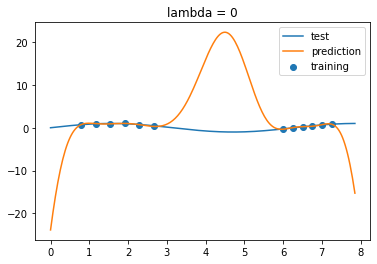

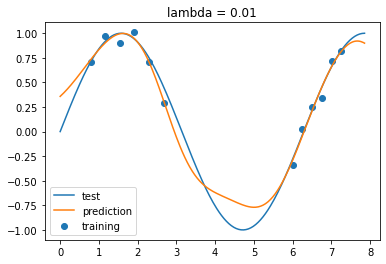

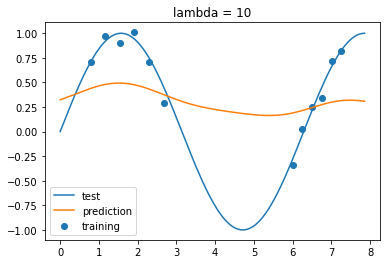

In [10]:
# plot train set as points
#plot ytest as line
#plot w as line

#calculate w 
#for 


#plt.figure(figsize = 8,9)
lamList = [0, 0.01, 10]

for lam in lamList:
    #calculate w for all values of lambda
    w = fit_pls(PHI_train, t_train, lam)
    y = PHI_test@w
    
    plt.figure()
    
    #figure.title(label = lam)
    plt.title(label = 'lambda = '+str(lam))
    plt.scatter(x_train, t_train, label = 'training')
    plt.plot(x_test, t_test, label = 'test')
    plt.plot(x_test,y, label = 'prediction')
    plt.legend()
    plt.show
#plt.scatter(range(12),div)

Next we Write a function `compute_posterior` to compute the posterior mean $\mathbf{\mu}$ and covariance $\mathbf{\Sigma}$ for the Bayesian linear regression model with basis matrix $\mathbf{\Phi}$ and with hyperparameters $\alpha$ and $\sigma^2$.

We will verify the consistency of the posterior code with `fit_pls` by comparing the outputs `w` and `Mu` (they should be the same, remembering that for equivalence, $\alpha = \lambda/\sigma^2$).

In [11]:
## POSTERIOR
##
def compute_posterior(PHI, t, alph, s2):
    #### **** YOUR CODE HERE **  ** ####
    #mu
    Mu = np.linalg.inv(PHI.T@PHI + s2*alph*np.identity(12))@PHI.T@t
    #sigma
    SIGMA = s2*np.linalg.inv((PHI.T@PHI + s2*alph*np.identity(12)))
    return Mu, SIGMA

alpha = 0.01/s2 

Mu, Sig = compute_posterior(PHI_train, t_train, alpha,s2)

print(Mu)

[[ 0.17542751]
 [-0.00686358]
 [ 0.27718726]
 [ 0.4473822 ]
 [ 0.49475058]
 [-0.47860652]
 [-0.30393321]
 [-0.3891278 ]
 [-0.60869482]
 [-0.02742655]
 [ 0.28990501]
 [ 0.5720677 ]]


In [12]:
w = fit_pls(PHI_train, t_train, 0.01)

print(w)

[[ 0.17542751]
 [-0.00686358]
 [ 0.27718726]
 [ 0.4473822 ]
 [ 0.49475058]
 [-0.47860652]
 [-0.30393321]
 [-0.3891278 ]
 [-0.60869482]
 [-0.02742655]
 [ 0.28990501]
 [ 0.5720677 ]]


Next we will write a function `compute_log_marginal` to compute the *logarithm* of the marginal likelihood for the Bayesian linear regression model with basis matrix $\mathbf{\Phi}$ and with hyperparameters $\alpha$ and $\sigma^2$.

In [13]:
## MARGINAL LIKELIHOOD
##
def compute_log_marginal(PHI, t, alph, s2):
    #### **** YOUR CODE HERE **** ####
    N = len(t)
    a = -N/2 * np.log(2*np.pi)
    b = (-1/2)*np.log(np.linalg.det(s2*np.identity(12)+(1/alph)*PHI@PHI.T))
    c = (-1/2)*t.T@np.linalg.inv(s2*np.identity(12) + (1/alph)*PHI@PHI.T)@t
    
    woodley = compute_log_marginal_Woodbury(PHI,t, alph, s2)

  
    
    lgp = a + b + c[0]
    

    return lgp

def compute_log_marginal_Woodbury(PHI,t, alph, s2):
    #
    #woodly matrix says that the inverse of a rank-k correction of some matrix can be
    #computed by doing a rank-k correction to the inverse of the original matrix.
    #this can be applied to calculate inverse used in c from the log marginal expression
    A = s2*np.identity(PHI.shape[0])

    U = PHI

    C = (1/alph)*np.identity(PHI.shape[1])

    V = PHI.T
    woodleyMat = np.linalg.inv(A) - np.linalg.inv(A)@U@(np.linalg.inv(np.linalg.inv(C)+V@(np.linalg.inv(A))@U))@V@(np.linalg.inv(A))
    
    N = len(t)
    a = -N/2 * np.log(2*np.pi)
    b = (-1/2)*np.log(np.linalg.det(s2*np.identity(12)+(1/alph)*PHI@PHI.T))
    c = (-1/2)*t.T@woodleyMat@t
    

    
    lgp = a + b + c[0]
    return lgp
    


Now we will wrire code to calculate the Gaussian RBF basis and the `t_train` data defined above.

<function matplotlib.pyplot.show(*args, **kw)>

<Figure size 432x288 with 0 Axes>

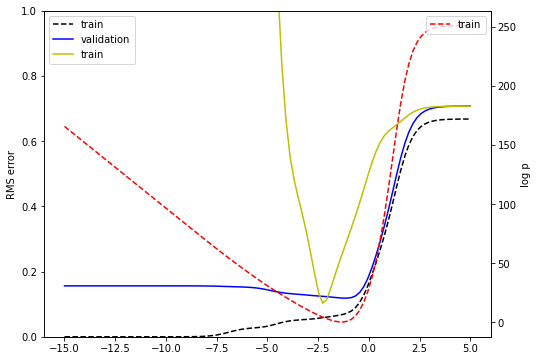

In [15]:
#log lambda
v = np.linspace(-15,5,100)

#v = np.linspace(1,5,5)

lambdaList = 10**v
errorTrain = []
errorVal = []
errorTest = []
Marg = np.zeros(len(v))

for i, lam in enumerate(lambdaList):
    
    #predict w
    w = fit_pls(PHI_train, t_train, lam)
    yTrain = PHI_train@w
    #w = fit_pls(PHI_val, t_train, lam)
    yVal = PHI_val@w
    yTest = PHI_test@w
    
    alph = lam/s2
    #calculate log marginals for each lambda 
    Marg[i] = -compute_log_marginal_Woodbury(PHI_train, t_train, alph, s2)
    
    #calculate errors
    
    errorTrain.append(lab1.error_rms(t_train,yTrain))
    errorVal.append(lab1.error_rms(t_val,yVal))
    errorTest.append(lab1.error_rms(t_test,yTest))
    


#plot values
plt.figure()

fig = plt.figure(figsize=(8, 6))
ax1 = fig.add_subplot(1, 1, 1)
ax2 = ax1.twinx()
ax1.plot(v,errorTrain, '--', c= 'k',label='train')
ax1.plot(v,errorVal, c= 'b',label='validation')
ax1.plot(v,errorTest, c= 'y',label='train')
ax2.plot(v,Marg, '--', c= 'r',label='train')




ax1.axes.set_ylim(0,1)

plt.xlabel('log lambda')

ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

ax1.set_ylabel('RMS error')
ax2.set_ylabel('log p')





plt.show




Next we will find the best value of $\alpha$ according to the marginal likelihood in Task the above, call `compute_posterior` to find the posterior mean weight vector `Mu` and use this to compute the posterior mean predictor (*i.e.* $y=\Phi\mu$) at all the test points `x_test`. Then using the `plot_regression` function, plot on the same axes:


<function matplotlib.pyplot.show(*args, **kw)>

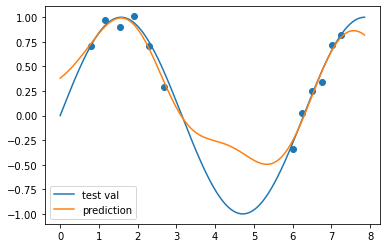

In [16]:
#calculate minimum alpha from marginal likelihood and use to find lambda

#find smallest marginal and its location

minMarg = np.min(np.array(Marg))


minMargLoc = np.where(Marg==minMarg)[0][0]

#print(minMargLoc)
minLam = lambdaList[minMargLoc]
minAlph = minLam/s2
#print('minLam',minLam)

#calculate mu
mu2, sigma = compute_posterior(PHI_train, t_train, minAlph, s2)

#prediction
y = PHI_test@mu2

plt.figure()

plt.scatter(x_train, t_train)
plt.plot(x_test, t_test, label ='test val')
plt.plot(x_test,y, label = 'prediction')
plt.legend()
plt.show

Next we will Repeat the graph above, for the same "best" predictor, but this time also compute the predictive variance at the points `x_test` and add them to the same plot as "error bars".

- By "error bars" we mean some multiple of the predictive standard deviation, and a multiple of 1 is fine, though other choices (*e.g.* 1.96 or 2.0) can be applicable,
- We expect to see larger error bars where there is no data.


In [20]:
MPsigma = s2
def serror(MPsigma, PHI,sigma):
    serror = MPsigma + PHI@sigma@PHI.T
    return serror


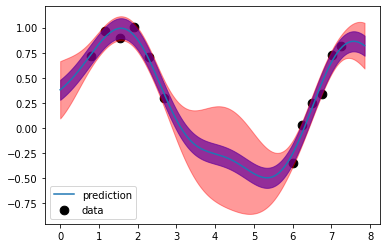

In [23]:
#calculate standard deviation points
stdPoint2 = np.diag(serror(s2, PHI_test,sigma))

stdPoint =np.sqrt(stdPoint2)


#plot results
plt.figure()

plt.scatter(x_train, t_train, s=75, c = 'k', marker ='o',label = 'data')
#plt.plot(x_test, t_test, label ='test val')
plt.plot(x_test,y, label = 'prediction')


stdNoise = [np.sqrt(s2)]*y.shape[0]
stdNoise = np.array(stdNoise)

#plot data noise

plt.fill_between(x_test.ravel(), (y.ravel()-stdNoise.ravel()).ravel(), (y.ravel()+stdNoise.ravel()).ravel(),color='blue', alpha=0.7)


#plot predictive uncertainty 
plt.fill_between(x_test.ravel(), (y.ravel()-stdPoint).ravel(), (y.ravel()+stdPoint).ravel(),color='red', alpha=0.4)

plt.legend()

plt.show()

Imagine we had built the above model for inclusion within some real-world system where it was desired to make predictions at some arbitrary points $x$ in the future. How might the information from the model's predictive variance be useful in the practical application?

Remember that the predictive model is an $x$-dependent Gaussian distribution over the prediction, and in principle the variance quantifies the likely error (which is a consequence both of the noise on the data and any model uncertainty).

We could look to address the following questions:

- how could the system exploit the predictive variance to practical advantage on new data?
- what evidence can you supply now (based on the existing test data set) to suggest the approach might work?


## Using the predictive variance in practice


<function matplotlib.pyplot.show(*args, **kw)>

<Figure size 432x288 with 0 Axes>

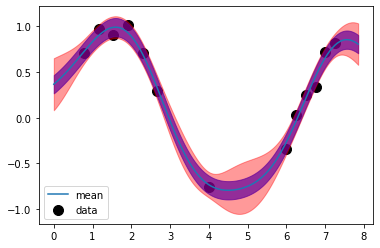

In [25]:
###Explaination###

#The predictive uncertainty contains 2 components the data noise and parameter uncertainty
#Adding more data points will result in shorter predictive uncertainty bands around the test points as it will only 
#contain the data noise and not the parameter uncertainty components. This is shown below in the graph 
#below where additional training points are added at x = 4 and t = sinx with noise of 0.0006. The data noise components 
#stays constant but the parameter uncertainty decreases around the new training point. So the bands are more squashed.
#This means that the prediction is much more confident around the new training 
#point as the prediction uncertainty converges to the data noise at all training points




#add the new training point

x = 4
e = 0.0006
t = np.sin(x)+ e

xtrainNew = np.append(x_train,x)[:,None]
ttrainNew = np.append(t_train,t)[:,None]


#train on basis functions
PHI_trainNew = basis.evaluate(xtrainNew)

#calculate mu and sigma
muNew, sigmaNew = compute_posterior(PHI_trainNew, ttrainNew, minAlph, s2)


#calculate parameter uncertainty
stdPointNew = np.diag(serror(s2, PHI_test,sigmaNew))

stdPointNew =np.sqrt(stdPointNew)

#plot values
plt.figure()


yNew = PHI_test@muNew

stdNoise = [np.sqrt(s2)]*yNew.shape[0]

stdNoise = np.array(stdNoise)

stdVar = stdPointNew-s2

fig, ax = plt.subplots()

ax.scatter(xtrainNew, ttrainNew, s = 100, c= 'k', marker ='o', label = 'data')

ax.plot(x_test, yNew, label = 'mean')

x_test = x_test.flatten()
yNoise = (yNew - 0.1).flatten()

#plot data noise

plt.fill_between(x_test.ravel(), (yNew.ravel()-stdNoise.ravel()).ravel(), (yNew.ravel()+stdNoise.ravel()).ravel(),color='blue', alpha=0.7)


#plot predictive uncertainty
ax.fill_between(x_test.flatten(), (yNew.flatten() - stdPointNew), (yNew.flatten() + stdPointNew),color='red', alpha=0.4)
plt.legend()

plt.show
